In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn
import os
from datetime import datetime, timedelta
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, TimeDistributed, LeakyReLU, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,TensorBoard

/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
os.listdir('./data/')

['DJI_ema.csv',
 'DJI_STO_20period_sma10.csv',
 'DJI_modified_sma.csv',
 '.DS_Store',
 'DJI_modified_features - DJI.csv',
 'nk_fe.csv',
 'DJI_fe.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 'N225fillVOL.csv',
 'test_djia.csv',
 'DJI_denoise.csv',
 'N225.csv',
 'stocknews',
 'preprocessed',
 'downjone5y.csv']

In [3]:
df_nikkei = pd.read_csv('./data/N225withoutNULL.csv')
df_djia = pd.read_csv('./data/DJI_modified_sma.csv')

In [4]:
df_nikkei.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0
3,1985-02-01,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,0
4,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0


In [5]:
df_djia['Date'][0]

'1985-01-29'

# Preprocess

In [6]:
# postpone 1 day and concatenate both table

# decrement datetime of djia first
df_djia_dc = df_djia.copy()
# df_djia_dc['Date'] = df_djia['Date'] + timedelta(days=-1)
for i in tqdm(range(len(df_djia))):
    df_djia_dc['Date'][i] = str((datetime.strptime(df_djia.iloc[i]['Date'], '%Y-%m-%d') + timedelta(days=-1)).date())

# df_djia_dc.head()
df = pd.merge(df_nikkei, df_djia_dc, on='Date', how='inner')
df = df.rename({'Open_x': 'Open(Nikkei)', 'High_x': 'High(Nikkei)', 'Low_x': 'Low(Nikkei)', 'Close_x': 'Close(Nikkei)',
                'Open_y': 'Open(DJIA)', 'High_y': 'High(DJIA)', 'Low_y': 'Low(DJIA)', 'Close_y': 'Close(DJIA)'
               }, axis=1)


  0%|          | 0/8762 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 8762/8762 [00:21<00:00, 409.20it/s]


In [7]:
df.head()

,Date,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Adj Close_x,Volume_x,Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA),Adj Close_y,Volume_y,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
3,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0,1294.060059,1301.130005,1278.599976,1285.229980,1285.229980,13800000,1285.535986,1285.229980,1285.229980,1285.229980,1285.229980,1285.229980
4,1985-02-05,11823.429688,11823.429688,11823.429688,11823.429688,11823.429688,0,1284.890015,1294.500000,1275.069946,1280.589966,1280.589966,14610000,1284.077979,1280.589966,1280.589966,1280.589966,1280.589966,1280.589966


In [8]:
event_col = ['Open(Nikkei)', 'High(Nikkei)', 'Low(Nikkei)', 'Close(Nikkei)',
            'Open(DJIA)', 'High(DJIA)', 'Low(DJIA)', 'Close(DJIA)'
            ]
total_col = df.columns
for col in total_col:
    if col not in event_col:
        df = df.drop(col, axis=1)

In [9]:
df.tail()

,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
6906,22619.769531,22648.810547,22457.890625,22625.380859,26893.92969,26931.77930,26714.33984,26805.52930
6907,22725.439453,22780.990234,22704.330078,22750.599609,26789.60938,27015.36914,26765.67969,26958.06055
6908,22854.439453,22896.220703,22830.570313,22867.269531,27061.07031,27165.93945,27039.75977,27071.46094
6909,22950.789063,23008.429688,22935.349609,22974.130859,27110.71094,27204.35938,26999.64063,27186.68945
6910,22953.169922,22961.230469,22827.929688,22843.119141,27188.36914,27188.36914,26918.28906,27046.23047


In [10]:
def normalize_data(df, event_col):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    for col in event_col:
        if col != 'Date':
            df[col] = min_max_scaler.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]
    

In [11]:
# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_norm = normalize_data(df, event_col)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (5513, 19, 8)
y_train.shape =  (5513, 8)
x_val.shape =  (689, 19, 8)
y_val.shape =  (689, 8)
x_test.shape =  (689, 19, 8)
y_test.shape =  (689, 8)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


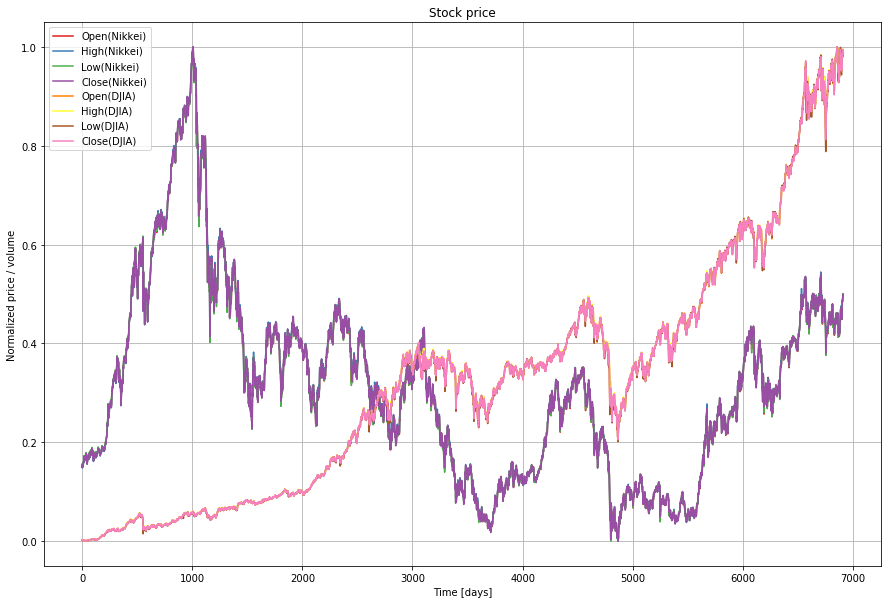

In [12]:
# plot graph before train

# !set color in graph
# color_palette = ...
plt.figure(figsize=(15, 10))
plt.grid()
color_palette = plt.get_cmap('Set1')
for i, col in enumerate(event_col):
    plt.plot(df_norm[col], color=color_palette(i), label=col)
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend()
plt.show()

In [13]:
start = 0
for i in range(df.shape[0]) :
    if df.loc[i]['Close(DJIA)'] >= df.loc[i]['Close(Nikkei)'] :
        start = i
        break
print(start)
df_2 = df[start:]
df_2

2638


,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
2638,0.258003,0.256758,0.237947,0.243070,0.252139,0.251625,0.248385,0.247049
2639,0.258003,0.256758,0.237947,0.243070,0.247315,0.248459,0.247263,0.245836
2640,0.247327,0.270863,0.249590,0.258785,0.246054,0.247600,0.247225,0.246570
2641,0.243875,0.243346,0.235396,0.242311,0.251280,0.255440,0.252319,0.255637
2642,0.244138,0.256102,0.246399,0.257487,0.255874,0.256852,0.255978,0.255342
...,...,...,...,...,...,...,...,...
6906,0.488358,0.488062,0.485756,0.488699,0.983626,0.983267,0.980601,0.979176
6907,0.491674,0.492212,0.493498,0.492630,0.979626,0.986467,0.982577,0.985018
6908,0.495723,0.495829,0.497464,0.496292,0.990036,0.992232,0.993125,0.989362
6909,0.498747,0.499351,0.500755,0.499646,0.991939,0.993703,0.991581,0.993776


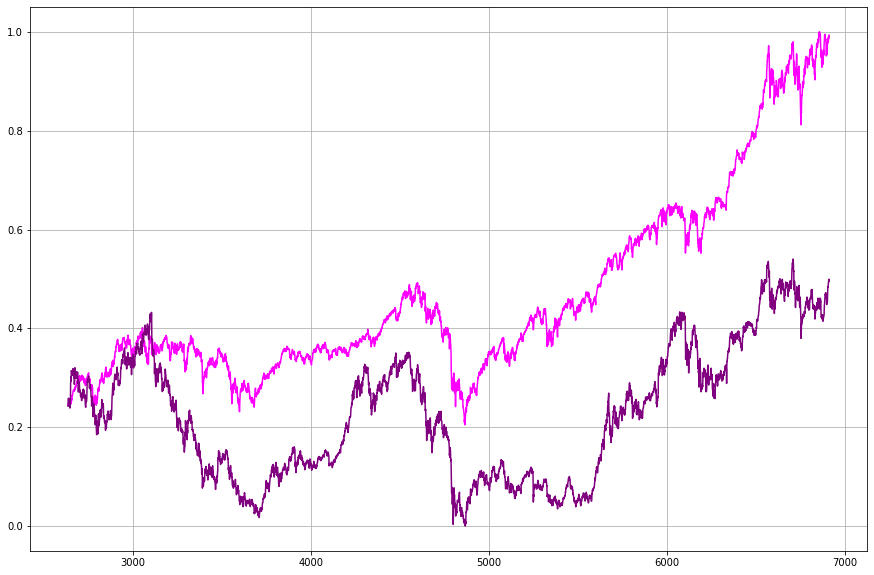

In [14]:
# plot graph after 2 graph sync

# !set color in graph
# color_palette = ...
plt.figure(figsize=(15, 10))
plt.grid()
color_palette = plt.get_cmap('Set1')
plt.plot(df_2['Close(DJIA)'],color='magenta')
plt.plot(df_2['Close(Nikkei)'],color='purple')

In [15]:
# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_2_norm = normalize_data(df_2, event_col)

# split train, val, test data

x2_train, y2_train, x2_val, y2_val, x2_test, y2_test = load_data(df_2_norm, seq_len)

print('x_train.shape = ', x2_train.shape)
print('y_train.shape = ', y2_train.shape)
print('x_val.shape = ', x2_val.shape)
print('y_val.shape = ', y2_val.shape)
print('x_test.shape = ', x2_test.shape)
print('y_test.shape = ', y2_test.shape)

x_train.shape =  (3403, 19, 8)
y_train.shape =  (3403, 8)
x_val.shape =  (425, 19, 8)
y_val.shape =  (425, 8)
x_test.shape =  (425, 19, 8)
y_test.shape =  (425, 8)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [16]:
df_2_norm

,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
2638,0.474720,0.471511,0.439808,0.449848,0.061221,0.051805,0.058767,0.052873
2639,0.474720,0.471511,0.439808,0.449848,0.055165,0.047793,0.057362,0.051347
2640,0.455077,0.497415,0.461328,0.478932,0.053581,0.046705,0.057315,0.052270
2641,0.448725,0.446881,0.435092,0.448443,0.060142,0.056639,0.063694,0.063675
2642,0.449209,0.470308,0.455429,0.476530,0.065909,0.058427,0.068276,0.063304
...,...,...,...,...,...,...,...,...
6906,0.898570,0.896280,0.897844,0.904434,0.979446,0.978799,0.975707,0.973806
6907,0.904672,0.903900,0.912153,0.911707,0.974425,0.982854,0.978181,0.981155
6908,0.912122,0.910542,0.919483,0.918484,0.987492,0.990158,0.991391,0.986619
6909,0.917686,0.917011,0.925567,0.924691,0.989882,0.992022,0.989458,0.992170


# Training

In [17]:
# hyperparameter 
batch_size = 1000
epochs = 500

# set up callback_list
weight_path_model = "saved_model/model_djia_support_nikkei_sync_period_V2.h5"
tensorboard_path = 'Graph/djia_support_nikkei_sync_period_V2'
callbacks_list_model = [
    TensorBoard(log_dir=tensorboard_path),
    ModelCheckpoint(
            weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=1e-9)
]

In [18]:
K.clear_session()

def get_bi_gru():
    
    input1 = Input(shape=(19,8,))
    x = GRU(256,return_sequences=True,kernel_initializer='Orthogonal')(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(8,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(lr=1e-2, decay=1e-2),
                loss='mse',
                metrics=['mse'])   
    
    return model

model = get_bi_gru()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 8)]           0         
_________________________________________________________________
gru (GRU)                    (None, 19, 256)           203520    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 256)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 256)           1024      
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               147840    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512   

# Experiment and Result

In [19]:
history = model.fit(x_train, y_train, epochs=epochs , callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) 

Train on 5513 samples, validate on 689 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
5000/5513 [==========================>...] - ETA: 1s - loss: 3.0930 - mean_squared_error: 3.0930
Epoch 00001: val_loss improved from inf to 0.14129, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 14s 3ms/sample - loss: 2.8852 - mean_squared_error: 2.8851 - val_loss: 0.1413 - val_mean_squared_error: 0.1413
Epoch 2/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.6921 - mean_squared_error: 0.6921
Epoch 00002: val_loss did not improve from 0.14129
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.6829 - mean_squared_error: 0.6829 - val_loss: 0.2918 - val_mean_squared_error: 0.2918
Epoch 3/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.6990 - mean_squared_error: 0.6990
Epoch 00003: val_loss did not improve from 0.1

5000/5513 [==========================>...] - ETA: 0s - loss: 0.1019 - mean_squared_error: 0.1019
Epoch 00022: val_loss improved from 0.04579 to 0.04422, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.1011 - mean_squared_error: 0.1011 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 23/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0959 - mean_squared_error: 0.0959
Epoch 00023: val_loss improved from 0.04422 to 0.04421, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 24/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0905 - mean_squared_error: 0.0905
Epoch 00024: val_loss did not improve from 0.04421
5513/5513 [==============================] - 8s 1ms/sample - loss:

Epoch 47/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0437 - mean_squared_error: 0.0437
Epoch 00047: val_loss improved from 0.04205 to 0.04104, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 48/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0424 - mean_squared_error: 0.0424
Epoch 00048: val_loss improved from 0.04104 to 0.03973, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0397 - val_mean_squared_error: 0.0397
Epoch 49/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0411 - mean_squared_error: 0.0411
Epoch 00049: val_loss improved from 0.03973 to 0.03869, saving model to saved_model/model_djia_support_n

Epoch 69/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0302 - mean_squared_error: 0.0302
Epoch 00069: val_loss improved from 0.02766 to 0.02757, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 70/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0298 - mean_squared_error: 0.0298
Epoch 00070: val_loss improved from 0.02757 to 0.02636, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 71/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0290 - mean_squared_error: 0.0290
Epoch 00071: val_loss improved from 0.02636 to 0.02570, saving model to saved_model/model_djia_support_n

5000/5513 [==========================>...] - ETA: 0s - loss: 0.0225 - mean_squared_error: 0.0225
Epoch 00090: val_loss improved from 0.01708 to 0.01637, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 91/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.0224
Epoch 00091: val_loss improved from 0.01637 to 0.01608, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 8s 2ms/sample - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 92/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 00092: val_loss improved from 0.01608 to 0.01546, saving model to saved_model/model_djia_support_nikkei_sync_pe

Epoch 113/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0176 - mean_squared_error: 0.0176
Epoch 00113: val_loss improved from 0.01213 to 0.01194, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 114/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 00114: val_loss did not improve from 0.01194
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 115/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 00115: val_loss improved from 0.01194 to 0.01190, saving model to saved_model/model_djia_support_nikkei_sync_period_V2.h5
5513/5513 [==============================] - 8s 1m

5000/5513 [==========================>...] - ETA: 0s - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 00137: val_loss did not improve from 0.01069
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 138/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 00138: val_loss did not improve from 0.01069
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 139/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 00139: val_loss did not improve from 0.01069
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 140/500
5000/5513 [==========================>...] - ETA:

5000/5513 [==========================>...] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 00161: val_loss did not improve from 0.01037
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 162/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 00162: val_loss did not improve from 0.01037
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 163/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 00163: val_loss did not improve from 0.01037
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 164/500
5000/5513 [==========================>...] - ETA:

Epoch 186/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 00186: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 187/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 00187: val_loss did not improve from 0.01021
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 188/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 00188: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 189/500
5000/5513 [========================

Epoch 212/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 00212: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 213/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00213: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 214/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00214: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 215/500
5000/5513 [========================

Epoch 238/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00238: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 239/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00239: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 240/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00240: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 241/500
5000/5513 [========================

Epoch 264/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 00264: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 265/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 00265: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 266/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00266: val_loss did not improve from 0.01021
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 267/500
5000/5513 [========================

Epoch 290/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 00290: val_loss did not improve from 0.01021
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 291/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 00291: val_loss did not improve from 0.01021
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 292/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 00292: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 293/500
5000/5513 [========================

Epoch 316/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 00316: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 317/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00317: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 318/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 00318: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 319/500
5000/5513 [========================

Epoch 342/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 00342: val_loss did not improve from 0.01021
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 343/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 00343: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 344/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00344: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 345/500
5000/5513 [========================

Epoch 368/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 00368: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 369/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 00369: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 370/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00370: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 371/500
5000/5513 [========================

Epoch 394/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 00394: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 395/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 00395: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 396/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 00396: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 397/500
5000/5513 [========================

Epoch 420/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 00420: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 421/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 00421: val_loss did not improve from 0.01021
5513/5513 [==============================] - 7s 1ms/sample - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 422/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00422: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 423/500
5000/5513 [========================

Epoch 446/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 00446: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 447/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 00447: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 448/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 00448: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 449/500
5000/5513 [========================

Epoch 472/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 00472: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 473/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 00473: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 474/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 00474: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 475/500
5000/5513 [========================

Epoch 498/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 00498: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 499/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 00499: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 500/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 00500: val_loss did not improve from 0.01021
5513/5513 [==============================] - 8s 1ms/sample - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


In [20]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


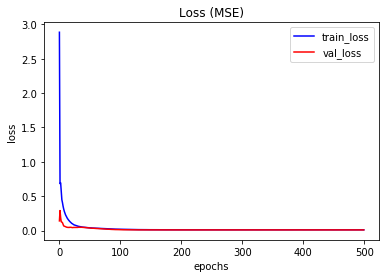

In [21]:
plt.title("Loss (MSE)")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig('loss_support_sync_data2.png')

In [22]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [25]:
#fix!
def plot_compare(x, event_col):
#     Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    Col = dict()
    count = 0
    for i, col in enumerate(event_col):
        Col[col] = i
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



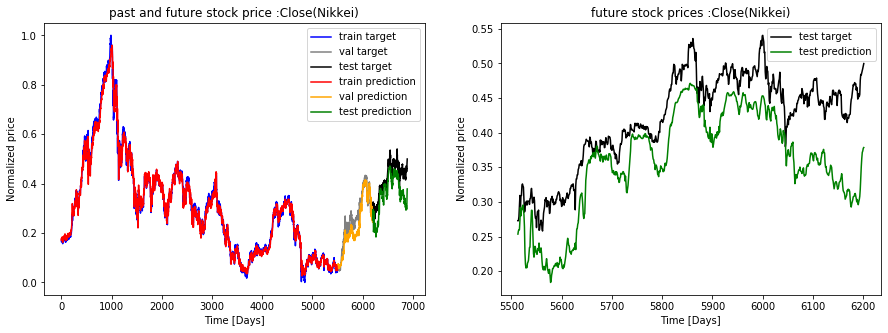

In [26]:
plot_compare('Close(Nikkei)', event_col)

In [27]:
model.evaluate(x_test,y_test)

689/689 [==============================] - 1s 1ms/sample - loss: 0.0751 - mean_squared_error: 0.0751


[0.07512192406484801, 0.075121924]

In [28]:
model.evaluate(x_val,y_val)

689/689 [==============================] - 0s 279us/sample - loss: 0.0102 - mean_squared_error: 0.0102


[0.010223456000144146, 0.010223455]

In [29]:
model.evaluate(x_train,y_train)

5513/5513 [==============================] - 2s 275us/sample - loss: 2.9969e-04 - mean_squared_error: 2.9969e-04


[0.00029969300091389615, 0.00029969294]